In [1]:
#Scikit-learn: a Python tool for data preprocessing, model training, and evaluation.
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import missingno as msno
import os
import datetime

# Use os for make a root
data_path = os.path.join("..", "..", "..", "..", "backend", "data", "covid_processed.csv")
data = pd.read_csv(data_path, sep=',')

data.head(10)

,date,location,total_cases,new_cases,total_deaths,new_deaths,icu_patients,hosp_patients,total_vaccinations,people_vaccinated
0,2020-01-05,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,2020-01-06,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,2020-01-07,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,2020-01-08,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,2020-01-09,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
5,2020-01-10,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
6,2020-01-11,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
7,2020-01-12,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
8,2020-01-13,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
9,2020-01-14,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [2]:
# Informations about data type and length
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429435 entries, 0 to 429434
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   date                429435 non-null  object 
 1   location            429435 non-null  object 
 2   total_cases         411804 non-null  float64
 3   new_cases           410159 non-null  float64
 4   total_deaths        411804 non-null  float64
 5   new_deaths          410608 non-null  float64
 6   icu_patients        39116 non-null   float64
 7   hosp_patients       40656 non-null   float64
 8   total_vaccinations  85417 non-null   float64
 9   people_vaccinated   81132 non-null   float64
dtypes: float64(8), object(2)
memory usage: 32.8+ MB


In [3]:
# Checking all the missing value in the data 
data.isnull().sum()

date                       0
location                   0
total_cases            17631
new_cases              19276
total_deaths           17631
new_deaths             18827
icu_patients          390319
hosp_patients         388779
total_vaccinations    344018
people_vaccinated     348303
dtype: int64

<Axes: >

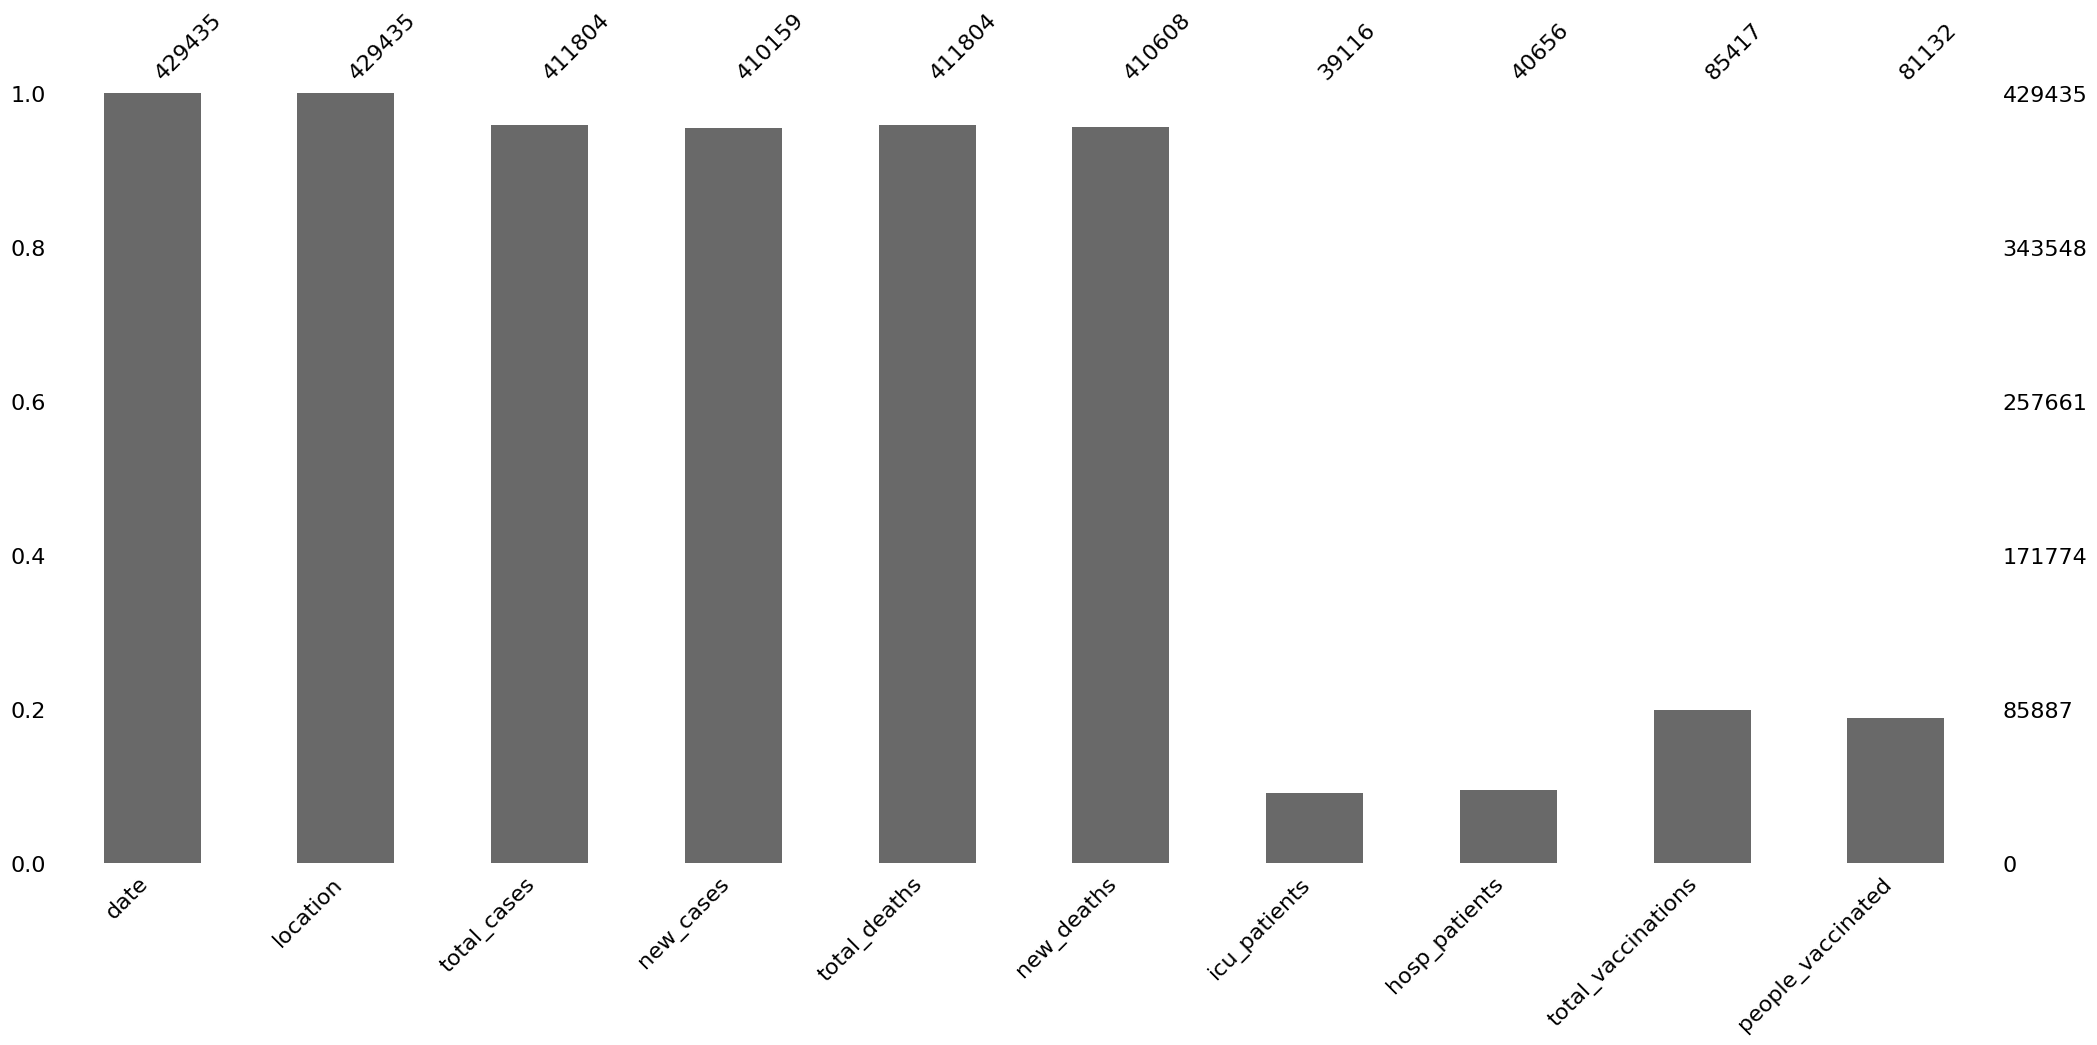

In [4]:
#comparatifvisualition on a diagram NaN values
msno.bar(data) 

In [5]:
# Drop column not usable
dataClean = data.drop(columns=['icu_patients', 'hosp_patients', 'total_vaccinations', 'people_vaccinated'])

In [ ]:
# Encodage de base
dataClean["date"] = pd.to_datetime(dataClean["date"], errors='coerce')
dataClean["location_encoded"] = LabelEncoder().fit_transform(dataClean["location"])
dataClean["day"] = dataClean["date"].dt.day
dataClean["month"] = dataClean["date"].dt.month
dataClean["year"] = dataClean["date"].dt.year

# Phase épidémique
dataClean["epidemic_phase"] = dataClean["year"].apply(lambda y: 0 if y <= 2022 else 1)

# Création de la cible : nombre de pays avec au moins un cas à une date donnée
propagation_df = dataClean[dataClean["new_cases"] > 0].groupby("date")["location"].nunique().reset_index()
propagation_df.rename(columns={"location": "countries_reporting"}, inplace=True)

# Fusion dans le DataFrame principal
dataClean = dataClean.merge(propagation_df, on="date", how="left")

# Features + Target
X = dataClean[[
    "total_cases", "location_encoded", "day", "month", "year",
    "total_deaths", "new_cases", "epidemic_phase"
]]
y = dataClean["countries_reporting"]  

# Nettoyage des valeurs manquantes
Xy = pd.concat([X, y], axis=1).dropna()
X = Xy[X.columns]
y = Xy[y.name]


In [ ]:
# 1Création de features dynamiques
dataClean["days_since_start"] = (dataClean["date"] - dataClean["date"].min()).dt.days
dataClean["new_cases_rolling7"] = dataClean["new_cases"].rolling(window=7).mean()
dataClean["trend_new_cases"] = dataClean["new_cases"].diff(periods=7)

# Séparation claire : entraînement sans 2023, test sur 2023
data_train = dataClean[dataClean["year"].isin([2020, 2021, 2022, 2024])]
data_test = dataClean[dataClean["year"] == 2023]

# Définition des features finales
features_final = [
    "total_cases", "location_encoded", "day", "month", "year",
    "total_deaths", "new_cases", "epidemic_phase",
    "days_since_start", "new_cases_rolling7", "trend_new_cases"
]

# Nettoyage
df_train = data_train[features_final + ["countries_reporting"]].dropna()
df_test = data_test[features_final + ["countries_reporting"]].dropna()

X_train = df_train[features_final]
y_train = df_train["countries_reporting"]

X_test = df_test[features_final]
y_test = df_test["countries_reporting"]

# Entraînement du modèle
model_eval = RandomForestRegressor(
        random_state=42,
        max_depth=10,  
        n_estimators=100,
        min_samples_split=5,
        min_samples_leaf=3
    )
model_eval.fit(X_train, y_train)

# Prédiction et évaluation
y_pred = model_eval.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mean_real = y_test.mean()
rel_error = mae / mean_real

print("\n🔬 Évaluation sur 2023 (non vu pendant l'entraînement)")
print(f"MAE : {mae:.2f}")
print(f"Erreur relative : {rel_error:.2%}")



🔬 Évaluation sur 2023 (non vu pendant l'entraînement)
MAE : 23.60
Erreur relative : 17.35%


In [ ]:
# MODELE FINAL : Entraînement complet sur 2020–2024 pour prédictions futures (Propagation géographique)

# Sélection des données jusqu'à 2024
data_global = dataClean[dataClean["year"] <= 2024]

# Nettoyage
df_global = data_global[features_final + ["countries_reporting"]].dropna()
X_global = df_global[features_final]
y_global = df_global["countries_reporting"]

# Entraînement
global_model = RandomForestRegressor(
        random_state=42,
        max_depth=10,  
        n_estimators=100,
        min_samples_split=5,
        min_samples_leaf=3
    )
global_model.fit(X_global, y_global)

# 4️ Évaluation sur l’ensemble d'entraînement
y_pred_global = global_model.predict(X_global)
mae_global = mean_absolute_error(y_global, y_pred_global)
rel_global = mae_global / y_global.mean()

print("\n Modèle final entraîné sur 2020–2024 (Propagation géographique)")
print(f"MAE : {mae_global:.2f}")
print(f"Erreur relative : {rel_global:.2%}")

date_predite = pd.to_datetime("2025-03-15")
days_since_start = (date_predite - dataClean["date"].min()).days

# Prédiction fictive pour un jour de 2025
exemple_2025 = pd.DataFrame([{ 
    "total_cases": 1_000_000,
    "location_encoded": 1, 
    "day": 1,
    "month": 5,
    "year": 2025,
    "total_deaths": 20000,
    "new_cases": 500,
    "epidemic_phase": 1,
    "days_since_start": days_since_start,
    "new_cases_rolling7": 520,
    "trend_new_cases": -30
}])

pred_2025 = global_model.predict(exemple_2025)
pred_2025 = np.maximum(pred_2025, 0)
print(" Prédiction du nombre de pays rapportant des cas (2025-03-15) :", pred_2025[0])



🔧 Modèle final entraîné sur 2020–2024 (Propagation géographique)
MAE : 0.60
Erreur relative : 0.35%

🌍 Prédiction du nombre de pays rapportant des cas (01/05/2025) : 71.76


In [9]:
# Étape 1 : filtrer les dates avec au moins un pays rapportant des cas
with_reporting = dataClean[dataClean["countries_reporting"] > 0]

# Étape 2 : déterminer les localisations avec le plus de jours renseignés
valid_country_counts = with_reporting.groupby("location")["countries_reporting"].count().sort_values(ascending=False)

# Étape 3 : exclure les agrégats (continents, income groups, etc.)
valid_country_counts = valid_country_counts[~valid_country_counts.index.str.contains("income|countries|Union|World|Asia|Europe|America|Africa")]

# Top pays exploitables
print(valid_country_counts.head(10))


location
East Timor             385
Faroe Islands          296
Angola                 240
Antigua and Barbuda    240
Argentina              240
Armenia                240
Anguilla               240
Albania                240
Afghanistan            240
Austria                240
Name: countries_reporting, dtype: int64


In [10]:
argentina_code = dataClean[dataClean["location"] == "Argentina"]["location_encoded"].unique()[0]
print("Code encodé pour l'Argentine :", argentina_code)


Code encodé pour l'Argentine : 9


In [ ]:
# Extraire les données de fin 2024 pour l'Argentine
argentina_data = dataClean[(dataClean["location"] == "Argentina") & (dataClean["year"] == 2024)].dropna()

# Calcul des statistiques moyennes
mean_total_cases = argentina_data["total_cases"].max()
mean_total_deaths = argentina_data["total_deaths"].max()
mean_new_cases = argentina_data["new_cases"].rolling(window=7).mean().iloc[-1]
mean_trend_cases = argentina_data["new_cases"].diff(periods=7).iloc[-1]

# Affichage
print("Exemple : Argentina — valeurs moyennes fin 2024")
print("Total cases :", mean_total_cases)
print("Total deaths :", mean_total_deaths)
print("New cases (rolling 7) :", mean_new_cases)
print("Trend new cases :", mean_trend_cases)


📊 Exemple : Argentina — valeurs moyennes fin 2024
Total cases : 10101218.0
Total deaths : 130663.0
New cases (rolling 7) : 88.71428571428571
Trend new cases : -79.0


In [ ]:
# Exemple date de prédiction
date_predite = pd.to_datetime("2025-03-15")
days_since_start = (date_predite - dataClean["date"].min()).days

exemple_argentine_2025 = pd.DataFrame([{
    "total_cases": mean_total_cases,
    "location_encoded": 9, 
    "day": 15,
    "month": 3,
    "year": 2025,
    "total_deaths": mean_total_deaths,
    "new_cases": mean_new_cases,
    "epidemic_phase": 1,
    "days_since_start": days_since_start,  
    "new_cases_rolling7": mean_new_cases,
    "trend_new_cases": mean_trend_cases
}])

# Prédiction de la propagation géographique (nombre de pays)
pred_geo_2025 = global_model.predict(exemple_argentine_2025)
pred_geo_2025 = np.maximum(pred_geo_2025, 0)

print("Prédiction propagation géographique (nombre de pays ayant déclaré un cas le 15 mars 2025) :", pred_geo_2025[0])


🌍 Prédiction propagation géographique (nombre de pays ayant déclaré un cas le 15 mars 2025) : 71.76
